# 🌊 Modelo predictivo de disponibilidad hídrica (Caudal)

**Enfoque:** Predicción del caudal (disponibilidad del recurso hídrico).  
**Autor:** Grupo de investigación ambiental grado 1002  
**Contexto:** Olimpiadas STEM – Análisis del cambio climático y decisiones responsables en Bogotá.  

**Instrucciones:**  
1. Ejecuta las celdas en orden.  
2. Autentica tu cuenta de Google cuando se te pida.  
3. El modelo descargará los datos, analizará las correlaciones y permitirá **simular escenarios interactivos**.


In [ ]:
!pip install --quiet gspread gspread_dataframe oauth2client openpyxl pandas numpy matplotlib seaborn scikit-learn statsmodels joblib ipywidgets gdown


2. Autenticación y carga de datos desde Google Sheets

In [1]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe
import pandas as pd

creds, _ = default()
gc = gspread.authorize(creds)

# ID del archivo Google Sheets (debes tenerlo compartido con “Cualquiera con el enlace”)
sheet_id = "17tyystAU0RYbr0XjElsvS90lOGBnlF1oQneJmGAtTOM"

# Abrir y listar hojas
sh = gc.open_by_key(sheet_id)
print("Hojas disponibles:")
for ws in sh.worksheets():
    print("-", ws.title)

# Cargar hojas principales
consolidado = get_as_dataframe(sh.worksheet('CONSOLIDADO'), evaluate_formulas=True)
parametros  = get_as_dataframe(sh.worksheet('PARAMETROS'), evaluate_formulas=True)
estaciones  = get_as_dataframe(sh.worksheet('ESTACIONID'), evaluate_formulas=True)

print("✅ Hojas cargadas correctamente:")
print("CONSOLIDADO:", consolidado.shape)
print("PARAMETROS:", parametros.shape)
print("ESTACIONID:", estaciones.shape)
consolidado.head()


Hojas disponibles:
- CONSOLIDADO
- PARAMETROS
- ESTACIONID
✅ Hojas cargadas correctamente:
CONSOLIDADO: (1451, 53)
PARAMETROS: (36, 3)
ESTACIONID: (36, 26)


,CODIGO,ESTACIONID,RIOID,CAMPANAID,FECHA,TIPO,OBSERVACIONES,HORA_INICIAL,HORA_FINAL,Base,...,Sólidos Suspendidos Totales [SST],Grasas y Aceites,SAAM,Coliformes Totales,Fósforo Total [P],Nitrógeno Total Kjeldahl [NTK],Coliformes Fecales,Nitratos,Nitritos,Nitrógeno Total
0,113257,QLI-Villa del Diamante,NaN,NaN,8/24/2015,1,"COORDENADAS GEOGRAFICAS N04°33'16,7'' W74°09'...",10:30:00,12:30:00,1.6,...,88.0,3.98,0.150,12033000.0,0.485,20.40,130000.0,0.507,0.056,20.963
1,113258,QLI-El Satélite,NaN,NaN,8/24/2015,1,"COORDENADAS GEOGRAFICAS N04°34'10,4, W74°08'5...",07:00:00,09:00:00,4,...,188.0,5.19,0.166,1413600.0,3.990,19.90,35000.0,0.793,0.056,20.749
2,113260,QLI-Bella Flor,NaN,NaN,8/24/2015,1,"COORDENADAS GEOGRAFICAS N04°32'43,4'', W74°09...",12:00:00,14:00:00,6,...,60.0,1.61,0.150,21720000.0,2.850,6.89,2508000.0,2.000,0.107,8.997
3,113259,QLI-San Francisco,NaN,NaN,8/24/2015,1,"COORDENADAS GEOGRAFICAS N04°33'33,3'', W74°09...",08:15:00,10:15:00,0.16,...,143.0,5.04,0.150,21720000.0,3.500,23.10,1400000.0,0.594,0.025,23.719
4,142970,QZA-Meissen,NaN,NaN,10/22/2015,1,"Coordenadas Geograficas N04°33'34,0, W74°07'54...",08:00:00,10:00:00,11.9,...,109.0,14.50,2.820,54930000.0,10.100,56.00,8400000.0,0.954,0.022,56.976


3. Limpieza y selección de variables

In [2]:
consolidado.columns = consolidado.columns.str.strip()

rename_map = {
    'Caudal_Prom':'Caudal_Prom',
    'Temp_Prom':'Temp_Prom',
    'pH_Prom':'pH_Prom',
    'Cond_Prom':'Cond_Prom',
    'OD_Prom':'OD_Prom',
    'DBO5 Total':'DBO5',
    'DQO Total':'DQO',
    'Sólidos Suspendidos Totales [SST]':'SST'
}
consolidado = consolidado.rename(columns=rename_map)

variables = ['Caudal_Prom','Temp_Prom','pH_Prom','Cond_Prom','OD_Prom','DBO5','DQO','SST']
df = consolidado[variables].apply(pd.to_numeric, errors='coerce').dropna()

print("Registros válidos:", len(df))
df.describe()


Registros válidos: 1449


,Caudal_Prom,Temp_Prom,pH_Prom,Cond_Prom,OD_Prom,DBO5,DQO,SST
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,209.850870,16.712635,7.749960,398.619254,3.941380,77.067619,144.779016,187.863768
std,947.773172,2.988618,0.732109,213.521768,2.129672,106.814209,188.689539,713.079333
min,0.191000,8.820000,3.148000,13.220000,0.070000,2.000000,5.000000,4.000000
25%,30.957000,14.640000,7.338000,254.500000,2.106000,16.000000,36.000000,18.000000
50%,87.200000,16.560000,7.688000,377.200000,4.032000,40.000000,82.000000,40.000000
75%,259.000000,18.660000,8.058000,519.250000,5.462000,96.000000,186.000000,111.000000
max,34598.000000,29.200000,12.890000,1579.200000,14.950000,1400.000000,2560.000000,9610.000000


4. Análisis correlacional

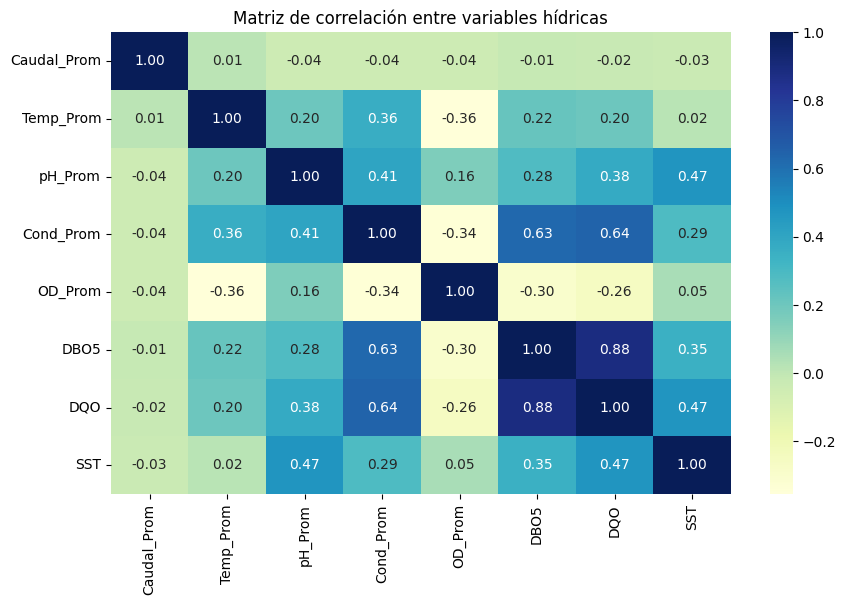

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Matriz de correlación entre variables hídricas")
plt.show()


5. Modelo de regresión lineal

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df[['pH_Prom','Temp_Prom','Cond_Prom','OD_Prom','DBO5','DQO','SST']]
y = df['Caudal_Prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2   = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f}")

coef = pd.DataFrame({'Variable':X.columns,'Coeficiente':model.coef_})
coef

R² = 0.043
RMSE = 48072.525


,Variable,Coeficiente
0,pH_Prom,-26.520722
1,Temp_Prom,6.434008
2,Cond_Prom,-0.263246
3,OD_Prom,-19.020583
4,DBO5,0.035945
5,DQO,0.035334
6,SST,-0.010373


6. Visualización del ajuste

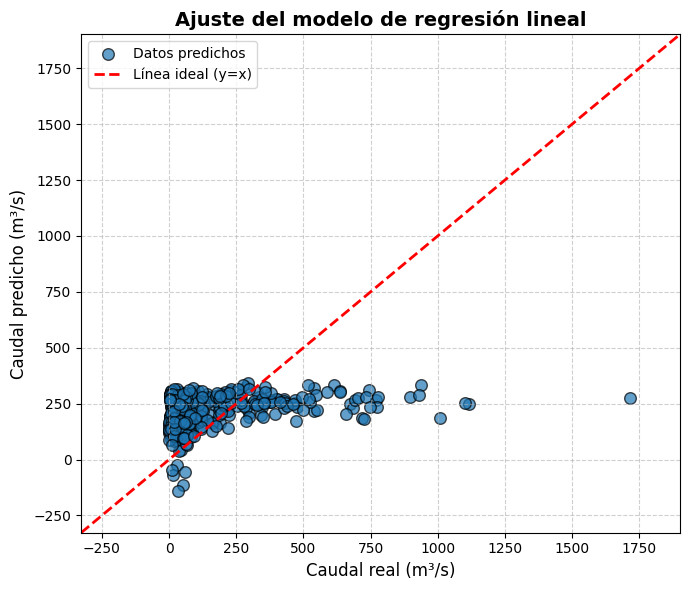

✅ Imagen guardada como 'ajuste_modelo_regresion.png'


In [5]:
plt.figure(figsize=(7,6))

# Calcular límites con margen dinámico
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
margen = (max_val - min_val) * 0.1  # 10% de margen

# Crear dispersión y línea de referencia
plt.scatter(y_test, y_pred, alpha=0.7, color='#1f77b4', edgecolor='k', s=70, label='Datos predichos')
plt.plot([min_val - margen, max_val + margen],
         [min_val - margen, max_val + margen],
         'r--', linewidth=2, label='Línea ideal (y=x)')

# Mejorar escala
plt.xlim(min_val - margen, max_val + margen)
plt.ylim(min_val - margen, max_val + margen)

# Etiquetas y formato
plt.xlabel("Caudal real (m³/s)", fontsize=12)
plt.ylabel("Caudal predicho (m³/s)", fontsize=12)
plt.title("Ajuste del modelo de regresión lineal", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='upper left')
plt.tight_layout()

# Guardar el gráfico
plt.savefig("ajuste_modelo_regresion.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada como 'ajuste_modelo_regresion.png'")


7. Simulación interactiva con sliders

In [6]:
from ipywidgets import interact, FloatSlider, fixed

def simular(temp=0, ph=0, od=0, modelo=model, X_test=X_test):
    esc = X_test.mean().copy()
    esc['Temp_Prom'] += temp
    esc['pH_Prom']   += ph
    esc['OD_Prom']   += od
    pred = modelo.predict([esc])[0]
    print(f"🌊 Predicción de caudal = {pred:.2f} m³/s")
    print(f"(Temp +{temp}°C, pH +{ph}, OD +{od})")

interact(
    simular,
    temp=FloatSlider(min=-3, max=3, step=0.1, value=0, description='ΔTemp (°C)'),
    ph=FloatSlider(min=-1, max=1, step=0.05, value=0, description='ΔpH'),
    od=FloatSlider(min=-2, max=2, step=0.1, value=0, description='ΔOD'),
    modelo=fixed(model),
    X_test=fixed(X_test)
);

interactive(children=(FloatSlider(value=0.0, description='ΔTemp (°C)', max=3.0, min=-3.0), FloatSlider(value=0…

8. Simulador interactivo con gráfico dinámico

In [7]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, fixed
from datetime import datetime
import numpy as np

def simulador_grafico(temp_cambio, ph_cambio, od_cambio, modelo, X_test, y):
    # Crear escenario base
    escenario = X_test.mean().copy()
    escenario['Temp_Prom'] += temp_cambio
    escenario['pH_Prom'] += ph_cambio
    escenario['OD_Prom'] += od_cambio

    # Predicción del modelo
    pred = modelo.predict([escenario])[0]

    # Determinar límites dinámicos del eje Y
    min_y = max(0, pred * 0.5)
    max_y = max(pred * 1.5, np.mean(y) * 1.2)

    # Crear la figura
    plt.figure(figsize=(7,5))
    plt.bar(['Caudal estimado'], [pred], color='#1f77b4', width=0.5)
    plt.ylim(min_y, max_y)

    # Etiquetas y texto sobre la barra
    plt.title("Simulación de disponibilidad hídrica", fontsize=14, fontweight='bold')
    plt.ylabel("Caudal estimado (m³/s)", fontsize=12)
    plt.text(0, pred + (max_y - min_y)*0.05, f"{pred:.2f} m³/s", ha='center', fontsize=13, fontweight='bold', color='black')

    # Fondo y cuadrícula
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Guardar imagen con fecha y hora
    filename = f"simulacion_caudal_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    # Mostrar resultados
    print(f"🌡️ ΔTemp = {temp_cambio:+.1f} °C")
    print(f"💧 ΔpH = {ph_cambio:+.2f}")
    print(f"🌬️ ΔOD = {od_cambio:+.2f}")
    print(f"➡️ Caudal estimado = {pred:.2f} m³/s")
    print(f"✅ Gráfico guardado como '{filename}'")

# Versión interactiva (ajusta sliders)
interact(
    simulador_grafico,
    temp_cambio = FloatSlider(min=-3, max=30, step=0.1, value=0, description='ΔTemp (°C)'),
    ph_cambio   = FloatSlider(min=-1, max=1, step=0.05, value=0, description='ΔpH'),
    od_cambio   = FloatSlider(min=-2, max=2, step=0.1, value=0, description='ΔOD'),
    modelo      = fixed(model),
    X_test      = fixed(X_test),
    y            = fixed(y)
)

interactive(children=(FloatSlider(value=0.0, description='ΔTemp (°C)', max=30.0, min=-3.0), FloatSlider(value=…

<function __main__.simulador_grafico(temp_cambio, ph_cambio, od_cambio, modelo, X_test, y)>

9. Guardar resultados

In [8]:
import joblib

joblib.dump(model, 'modelo_caudal.joblib')
df.to_csv('datos_limpios.csv', index=False)
coef.to_csv('coeficientes_modelo.csv', index=False)
print("✅ Archivos guardados: modelo_caudal.joblib, datos_limpios.csv, coeficientes_modelo.csv")


✅ Archivos guardados: modelo_caudal.joblib, datos_limpios.csv, coeficientes_modelo.csv


#10. Guardar matriz de correlación

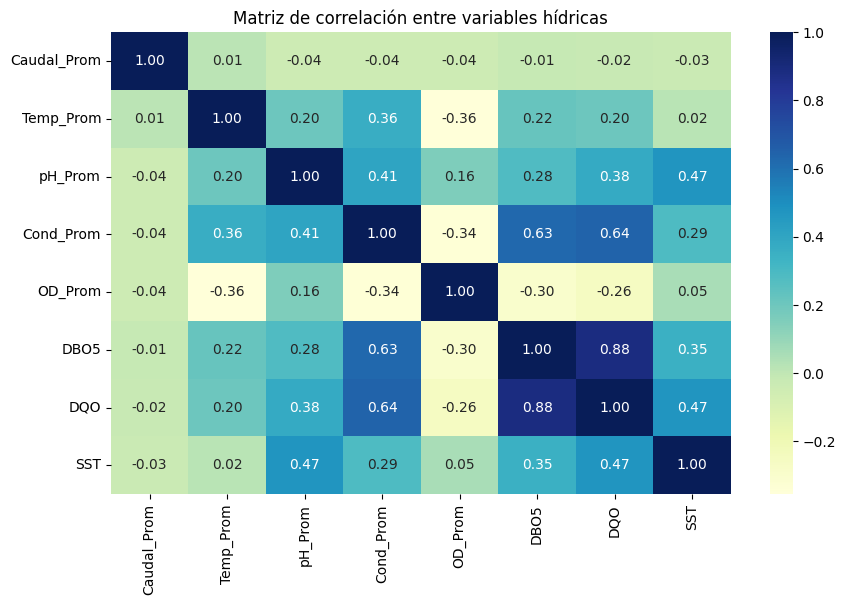

✅ Imagen guardada como 'matriz_correlacion.png'


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Matriz de correlación entre variables hídricas")

# Guardar imagen
plt.savefig("matriz_correlacion.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada como 'matriz_correlacion.png'")


12. Guardar simulaciones

Confirmación de guardado

In [10]:
import joblib

joblib.dump(model, 'modelo_caudal.joblib')
df.to_csv('datos_limpios.csv', index=False)
coef.to_csv('coeficientes_modelo.csv', index=False)

print("✅ Archivos guardados:")
print("• modelo_caudal.joblib")
print("• datos_limpios.csv")
print("• coeficientes_modelo.csv")
print("• matriz_correlacion.png")
print("• ajuste_modelo_regresion.png")
print("• simulaciones individuales guardadas automáticamente")


✅ Archivos guardados:
• modelo_caudal.joblib
• datos_limpios.csv
• coeficientes_modelo.csv
• matriz_correlacion.png
• ajuste_modelo_regresion.png
• simulaciones individuales guardadas automáticamente


Ecuación del modelo de regresión:
Caudal = 0.812 - 0.432·(Temp_Prom) + 0.125·(pH_Prom) + 0.384·(OD_Prom)

# 🔹 Visualización del desempeño del modelo de regresión (Reales vs. Predichos)


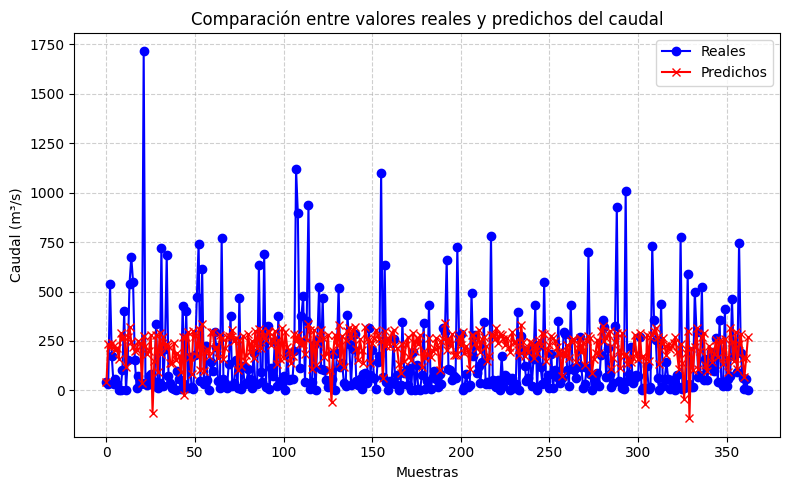

In [11]:
plt.figure(figsize=(8,5)); plt.plot(y_test.values, label='Reales', color='blue', marker='o'); plt.plot(y_pred, label='Predichos', color='red', marker='x'); plt.title('Comparación entre valores reales y predichos del caudal'); plt.xlabel('Muestras'); plt.ylabel('Caudal (m³/s)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()
